# MNIST handwritten digits - classification with CNNs - and analysis of results.
original code by Dr. Imme Ebert-Uphoff, updated for tutorial by Yoonjin Lee



In [1]:
# Choose one version below for envrionment setup.
  
# Version A:  Sets up environment as "Keras with Tensorflow backend".
# This is the standard set-up for using the visualization package "innvestigate".
# Good as DEVELOPMENT version, e.g., to use in CoLab.

# Version B:  Sets up environment as "Tensorflow with Keras on top".
# Currently does not support visualization package.
# This is the standard set-up for using the visualization package "Lucid".
# Use this version if you want to go very high performance.

%tensorflow_version 1.x

USE_VERSION_A = True  
#USE_VERSION_A = False  

if ( USE_VERSION_A ):  # Version A
  import keras
  import keras.backend
  import keras.models
  
  from keras.models import Sequential
  from keras.layers import Dense, Activation, Dropout, Flatten, MaxPooling2D, Conv2D
  from keras.utils import plot_model, to_categorical

else : # Version B
  import tensorflow as tf
  from tensorflow.keras.models import Sequential
  from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, MaxPooling2D, Conv2D
  from tensorflow.keras.utils import plot_model, to_categorical
  from tensorflow import keras


TensorFlow 1.x selected.


Using TensorFlow backend.


## Some more set-up

In [0]:
%matplotlib inline

from IPython.display import SVG

import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns


## Import MNIST data set: hand-written digits

In [3]:
#from tensorflow.keras.datasets import mnist

from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
nb_classes = 10

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
# Normalizing data to range from 0 to
X_train /= 255
X_test /= 255

# one-hot encoding: if the class was either 0 or 1 => [1,0] or [0,1]
Y_train = to_categorical(y_train, nb_classes)
Y_test = to_categorical(y_test, nb_classes)

print()
print('MNIST data loaded: train:',len(X_train),'test:',len(X_test))
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('Y_train:', Y_train.shape)

11493376/11490434 [==============================] - 1s 0us/step

MNIST data loaded: train: 60000 test: 10000
X_train: (60000, 28, 28)
y_train: (60000,)
Y_train: (60000, 10)


## Always know what your data looks like.  Print a few samples.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  # Remove the CWD from sys.path while we load stuff.


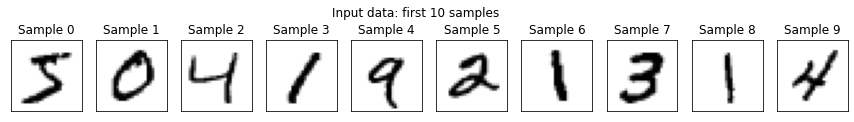

In [4]:
# Print first 10 samples
N_samples_to_show = 10;
fig, axs = plt.subplots(1,N_samples_to_show,figsize=(15, 2))
fig.suptitle('Input data: first {} samples'.format(N_samples_to_show))

for image_n in range(N_samples_to_show):
  my_image = X_train[image_n]
  axs[image_n].imshow(my_image, cmap='gray_r')  # 'gray' gives white on black.  
  axs[image_n].set_title('Sample {}'.format(image_n))
  axs[image_n].set_xticks([], [])
  axs[image_n].set_yticks([], [])
 
plt.show()

## Get data into the shape expected by a convolution layer.

In [5]:
# Prepare input for feeding into convolution layer.
# Expected input is of format (n_samples, img_rows, img_cols, n_channels).
n_samples_train = X_train.shape[0]
n_samples_test = X_test.shape[0]
img_rows, img_cols = 28, 28
n_channels = 1

# Adding a dummy dimension to have a 1-dimensional input channel. Last array is for feature maps (convolution with filters) after convolutional layers.
X_train = X_train.reshape(n_samples_train, img_rows, img_cols, n_channels)
X_test = X_test.reshape(n_samples_test, img_rows, img_cols, n_channels)
input_shape = (img_rows, img_cols, n_channels)
    
print('X_train:', X_train.shape)
print('X_test: ', X_test.shape)

X_train: (60000, 28, 28, 1)
X_test:  (10000, 28, 28, 1)


## Define neural network


In [6]:
# Define network architecture

# number of convolutional filters to use
nb_filters = 32
# convolution kernel size
kernel_size = (3, 3)
# size of pooling area for max pooling
pool_size = (2, 2)

model = Sequential()

# Convolution layer 1:  2D Convolution with (3x3) kernel + ReLu.
model.add(Conv2D(nb_filters, kernel_size, padding='valid', input_shape=input_shape))
model.add(Activation('relu'))
###batchnormalization if needed
#model.add(BatchNormalization())

# Convolution layer 2:  2D Convolution with (3x3) kernel + ReLu.
model.add(Conv2D(nb_filters, kernel_size))
model.add(Activation('relu'))

# Pooling layer  
model.add(MaxPooling2D(pool_size=pool_size))
# Drop-out layer to avoid overfitting
model.add(Dropout(0.25))

# Flatten image array to vector, so that we can feed it into densely connected layer.
model.add(Flatten())

# Densely connected layer: with Relu and dropout.
model.add(Dense(units=128))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Last layer: densely connected.
model.add(Dense(units=nb_classes))
# Note: last layer never uses RelU or similar as activation function.
# Activation function of last layer for regression problem:  none!
# Activation function of last layer for classification problem: softmax.
# Here we want to do classification --> use softmax.
model.add(Activation('softmax'))

# Choose crossentropy, because we're doing classification, not prediction.
# Make sure to include below ALL metrics you want to be measured during training!

model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(0.01),  # Adam optimizer
              metrics=[ 'categorical_accuracy'])

# Metrics collected in history:
# only categorical_accuracy makes sense for classification task
# Note: accuracy = categorical_accuracy for classification task


Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [7]:
# print model summary as table
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)             

## Training the network

Make sure you have GPUs enabled.  If not, got to "Edit", then "Notebook settings", then select "GPU".
(You may have to restart notebook after switching to GPU.)

In [8]:
%%time

epochs = 20  # 100

# Feed in not only training, but also testing data (2nd line below), 
# so that we can track the loss, etc., during learning also for test data.
# Important to spot overfitting!

history = model.fit(X_train, Y_train, 
                    validation_data= (X_test, Y_test),
                    epochs=epochs, batch_size=128, verbose=2)

# verbose: 0,1 or 2.  0 = silent, 1 = progress bar, 2 = one line per epoch.


Train on 60000 samples, validate on 10000 samples
Epoch 1/20
 - 12s - loss: 0.2349 - categorical_accuracy: 0.9277 - val_loss: 0.0560 - val_categorical_accuracy: 0.9829
Epoch 2/20
 - 6s - loss: 0.1208 - categorical_accuracy: 0.9642 - val_loss: 0.0525 - val_categorical_accuracy: 0.9837
Epoch 3/20
 - 6s - loss: 0.1054 - categorical_accuracy: 0.9688 - val_loss: 0.0458 - val_categorical_accuracy: 0.9844
Epoch 4/20
 - 6s - loss: 0.0958 - categorical_accuracy: 0.9715 - val_loss: 0.0508 - val_categorical_accuracy: 0.9836
Epoch 5/20
 - 6s - loss: 0.0958 - categorical_accuracy: 0.9725 - val_loss: 0.0442 - val_categorical_accuracy: 0.9876
Epoch 6/20
 - 6s - loss: 0.0919 - categorical_accuracy: 0.9727 - val_loss: 0.0436 - val_categorical_accuracy: 0.9877
Epoch 7/20
 - 6s - loss: 0.0924 - categorical_accuracy: 0.9724 - val_loss: 0.0520 - val_categorical_accuracy: 0.9851
Epoch 8/20
 - 6s - loss: 0.0904 - categorical_accuracy: 0.9729 - val_loss: 0.0429 - val_categorical_accuracy: 0.9874
Epoch 9/20
 

## Check convergence
Track loss and accuracy not only for training data, but also for test data, over epochs of training.  Do the plots indicate that this converged properly?  If not, then go back and make changes - no point to continue.

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy'])


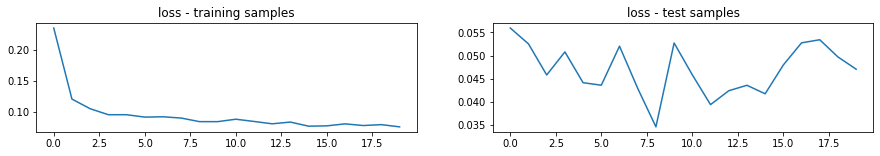

Note: loss here = categorical cross entropy



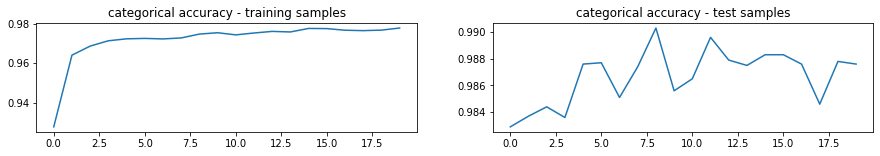

In [9]:
# provide names of items stored in history - these can be used in plots below
print(history.history.keys())

# Print evolution of loss - separately for training and test data
fig, axs = plt.subplots(1,2,figsize=(15, 2))
axs[0].plot(history.epoch,history.history['loss'])
axs[0].set_title('loss - training samples')
axs[1].plot(history.epoch,history.history['val_loss'])
axs[1].set_title('loss - test samples')
plt.show()
print('Note: loss here = categorical cross entropy\n')

# Print evolution of cat. accuracy - separately for training and test data
fig, axs = plt.subplots(1,2,figsize=(15, 2))
axs[0].plot(history.epoch,history.history['categorical_accuracy'])
axs[0].set_title('categorical accuracy - training samples')
axs[1].plot(history.epoch,history.history['val_categorical_accuracy'])
axs[1].set_title('categorical accuracy - test samples')
plt.show()


## Accuracy

With enough training epochs, the test accuracy should well exceed 98%.  Does it?



In [10]:
#%%time
scores = model.evaluate(X_test, Y_test, verbose=1)
# 0 = silent, 1 = progress bar.
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

10000/10000 [==============================] - 1s 99us/step

categorical_accuracy: 98.76%


In [0]:
def contingency_table_and_plots_for_single_class( predicted_class, i_class, WANT_PLOTS ):
  
  true_positive_indices = np.where( (y_test == i_class)  & ( predicted_class == i_class ) )[0]
  true_negative_indices = np.where( (y_test != i_class)  & ( predicted_class != i_class ) )[0]
  false_positive_indices = np.where( (y_test != i_class)  & ( predicted_class == i_class ) )[0]
  false_negative_indices = np.where( (y_test == i_class)  & ( predicted_class != i_class ) )[0]
  
  n_samples_this_class = sum( (y_test == i_class) )
  n_true_positives = len(true_positive_indices)
  n_true_negatives = len(true_negative_indices)
  n_false_positives = len(false_positive_indices)
  n_false_negatives = len(false_negative_indices)

  print('\nClass #{}:'.format(i_class))
  print('   Hits: {} ({:2.2%})    False alarm:       {} ({:2.2%})'
        .format(n_true_positives, n_true_positives/(n_true_positives + n_false_negatives), 
                n_false_positives, n_false_positives/(n_true_positives + n_false_negatives) ))
  print('   Miss: {} ({:2.2%})    Correct rejection: {} ({:2.2%})'
        .format(n_false_negatives, n_false_negatives/(n_false_positives + n_true_negatives), 
                n_true_negatives, n_true_negatives/(n_false_positives + n_true_negatives) ))
  
  
  if (WANT_PLOTS == True):
    
    N_false_pos = false_positive_indices.shape[0]
    print( '\nFalse alarms for class # {}:'.format(i_class))
    fig, axs = plt.subplots(1,N_false_pos,figsize=(2*N_false_pos, 2))
    
    i_image=0 # start new image counter
    for my_index in false_positive_indices:
      axs[i_image].imshow(X_test[my_index,:,:,0], cmap="gray_r")  # 'gray' gives white on black.  
      axs[i_image].set_title('True {}  Pred {}\n(Sample={})'.format(y_test[my_index],predicted_class[my_index], my_index) )
      axs[i_image].set_xticks([], [])
      axs[i_image].set_yticks([], [])
      i_image = i_image+1
      
    plt.show()

    N_false_neg = false_negative_indices.shape[0]
    print( '\nMisses for class # {}:'.format(i_class))
    fig, axs = plt.subplots(1,N_false_neg,figsize=(2*N_false_neg, 2))
    
    i_image=0 # start new image counter
    for my_index in false_negative_indices:
      axs[i_image].imshow(X_test[my_index,:,:,0], cmap="gray_r")  # 'gray' gives white on black.  
      axs[i_image].set_title('True {}  Pred {}\n(Sample={})'.format(y_test[my_index],predicted_class[my_index], my_index) )
      axs[i_image].set_xticks([], [])
      axs[i_image].set_yticks([], [])
      i_image = i_image+1
      
    plt.show()

  return true_positive_indices, true_negative_indices, false_positive_indices, false_negative_indices


## Get predictions for test samples and evaluate.

In [12]:
# Get predictions for all test samples from ANN:
predictions = model.predict(X_test)

# predicted class of each sample = class with highest probability
predicted_class = np.argmax(predictions, axis=1)  
  
# Note: Probabilities themselves are no longer used!
# We could do a lot more with this information - tells us how certain the model is!

# Evaluate results:
for i_class in range(10):
   contingency_table_and_plots_for_single_class( predicted_class, i_class, WANT_PLOTS = False )


Class #0:
   Hits: 976 (99.59%)    False alarm:       19 (1.94%)
   Miss: 4 (0.04%)    Correct rejection: 9001 (99.79%)

Class #1:
   Hits: 1131 (99.65%)    False alarm:       4 (0.35%)
   Miss: 4 (0.05%)    Correct rejection: 8861 (99.95%)

Class #2:
   Hits: 1023 (99.13%)    False alarm:       12 (1.16%)
   Miss: 9 (0.10%)    Correct rejection: 8956 (99.87%)

Class #3:
   Hits: 1000 (99.01%)    False alarm:       9 (0.89%)
   Miss: 10 (0.11%)    Correct rejection: 8981 (99.90%)

Class #4:
   Hits: 967 (98.47%)    False alarm:       6 (0.61%)
   Miss: 15 (0.17%)    Correct rejection: 9012 (99.93%)

Class #5:
   Hits: 885 (99.22%)    False alarm:       21 (2.35%)
   Miss: 7 (0.08%)    Correct rejection: 9087 (99.77%)

Class #6:
   Hits: 937 (97.81%)    False alarm:       5 (0.52%)
   Miss: 21 (0.23%)    Correct rejection: 9037 (99.94%)

Class #7:
   Hits: 1015 (98.74%)    False alarm:       7 (0.68%)
   Miss: 13 (0.14%)    Correct rejection: 8965 (99.92%)

Class #8:
   Hits: 963 (98.8


Class #3:
   Hits: 1000 (99.01%)    False alarm:       9 (0.89%)
   Miss: 10 (0.11%)    Correct rejection: 8981 (99.90%)

False alarms for class # 3:


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


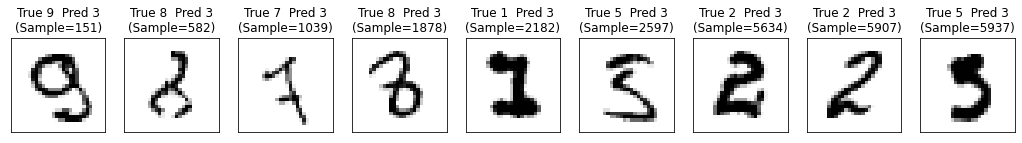


Misses for class # 3:


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


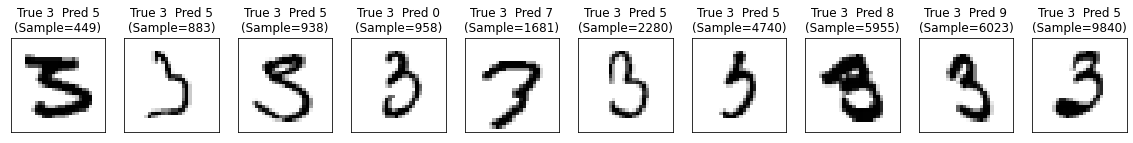

In [13]:
# Look at one class in more detail - print the unusual cases 
this_class = 3  # choose any class here

true_positive_indices, true_negative_indices, false_positive_indices, false_negative_indices = contingency_table_and_plots_for_single_class( predicted_class, this_class, WANT_PLOTS = True )